In [1]:
import pandas as pd
import numpy as np
import os
import torch
import pickle
import utilities
import preprocess
import similarities
import parameters
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader

In [2]:
result_file_name = 'embedding_tuning_opp115-4.p'

In [3]:
data = 'opp115'

In [4]:
embedding_methods = ['stsb-roberta-large',
                     'paraphrase-MiniLM-L6-v2',
                     'all-mpnet-base-v1',
                     'all-mpnet-base-v2',
                     'distiluse-base-multilingual-cased-v1']

In [5]:
random_state = parameters.random_state
np.random.seed(random_state)
data_paths = parameters.data_paths

In [6]:
df = utilities.read_data(data_paths[data])
X = df['text'].apply(preprocess.preprocess_text)
y = df.drop(['text'], axis=1)

In [7]:
def calculate_between_class_similarities(col1, col2, X, y):
    
    sims = []
    
    for idx1 in y[y[col1]==1].index:
        for idx2 in y[y[col2]==1].index:
            sims.append(similarities.vector_similarity(X.loc[idx1], X.loc[idx2]))
    
    return sum(sims)/len(sims)     

In [8]:
def calculate_similarity_matrix(X, y, sim_method='cosine'):
    
    import similarities
    
    sim_df = pd.DataFrame(index=y.columns, columns=y.columns)
    
    for col in y.columns:
    
        indexes = y[y[col]==1].index
        sim_df.loc[col, col] = similarities.calculate_within_class_similarity(X.loc[indexes], 'average')
    
    for col1, col2 in list(combinations(y.columns, 2)):
        sim_df.loc[col1, col2] = calculate_between_class_similarities(col1, col2, X, y)
    
    return sim_df

In [9]:
def calculate_matrix_score(sim_df):
    scores = []
    for col in sim_df.columns:
        scores.append((sim_df.loc[col, col] - sim_df.loc[col].drop(col).max())/sim_df.loc[col, col])
    return scores

In [10]:
def vectorize_data(text, model):
    
    # model = SentenceTransformer(model_name)
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    vectors = model.encode(text, convert_to_tensor=False, device=device)
    
    return vectors

In [11]:
sample_size_by_category = {'Data Retention':50, 'Data Security':20, 'Do Not Track':10,
                            'First Party Collection/Use':50, 'International and Specific Audiences':80,
                            'Introductory/Generic':80, 'Policy Change':10, 'Practice not covered':80,
                            'Privacy contact information':60, 'Third Party Sharing/Collection':50,
                            'User Access, Edit and Deletion':60, 'User Choice/Control':60}

In [12]:
improved_samples = {('Data Retention', 'First Party Collection/Use'): 100,
 ('Data Retention', 'International and Specific Audiences'): 100,
 ('Data Retention', 'Practice not covered'): 100,
 ('Data Retention', 'Privacy contact information'): 100,
 ('Data Retention', 'User Access, Edit and Deletion'): 100,
 ('Data Retention', 'User Choice/Control'): 100,
 ('Data Security', 'Introductory/Generic'): 100,
 ('First Party Collection/Use', 'Practice not covered'): 100,
 ('First Party Collection/Use', 'Third Party Sharing/Collection'): 100,
 ('First Party Collection/Use', 'User Access, Edit and Deletion'): 100,
 ('First Party Collection/Use', 'User Choice/Control'): 100,
 ('International and Specific Audiences', 'Introductory/Generic'): 100,
 ('International and Specific Audiences', 'Practice not covered'): 100,
 ('International and Specific Audiences', 'Privacy contact information'): 100,
 ('International and Specific Audiences',
  'User Access, Edit and Deletion'): 100,
 ('International and Specific Audiences', 'User Choice/Control'): 100,
 ('Practice not covered', 'Privacy contact information'): 100,
 ('Practice not covered', 'User Access, Edit and Deletion'): 100,
 ('Practice not covered', 'User Choice/Control'): 100,
 ('Privacy contact information', 'User Access, Edit and Deletion'): 100,
 ('Privacy contact information', 'User Choice/Control'): 100,
 ('User Access, Edit and Deletion', 'User Choice/Control'): 100}

In [13]:
def create_train_data(X, y, sample_size):
    
    train_set = []

    for col in y.columns:

        idxs = y[y[col]==1].index
        tmp_set = X.loc[idxs].sample(sample_size_by_category[col])

        for pair in combinations(tmp_set, 2):
            train_set.append(InputExample(texts=list(pair), label=1.0))

    for col1, col2 in combinations(y.columns,2):
        
        sample_num = improved_samples.get((col1, col2), sample_size)
        idxs1 = y[(y[col1]==1)&(y[col2]==0)].index
        idxs2 = y[(y[col2]==1)&(y[col1]==0)].index
        tmp_set1 = X.loc[idxs1].sample(sample_size)
        tmp_set2 = X.loc[idxs2].sample(sample_size)

        for pair in zip(tmp_set1, tmp_set2):
            train_set.append(InputExample(texts=list(pair), label=0.0))

    print(len(train_set))
    
    return train_set

In [14]:
if not os.path.exists(result_file_name):
    tuning_results = {}
    with open(result_file_name, 'wb') as f:
        pickle.dump(tuning_results, f)

In [15]:
with open(result_file_name, 'rb') as f:
    tuning_results = pickle.load(f)

In [16]:
iterate = [i for i in embedding_methods if i not in tuning_results.keys()]

In [17]:
for embedding_method in iterate:
    
    X_num = utilities.vectorize_data(X, embedding_method)
    sim_df_before = calculate_similarity_matrix(X_num, y)
    
    train_set = create_train_data(X, y, sample_size=25)
    model = SentenceTransformer(embedding_method, device='cuda') 

    train_dataloader = DataLoader(train_set, shuffle=True, batch_size=6)
    train_loss = losses.CosineSimilarityLoss(model)

    model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=20, warmup_steps=50)

    X_num_tuned = vectorize_data(X, model)
    X_num_tuned = pd.Series([np.squeeze(i) for i in X_num_tuned])
    sim_df_after = calculate_similarity_matrix(X_num_tuned, y)
    
    tuning_results[embedding_method] = (sim_df_before, sim_df_after)
    
    with open(result_file_name, 'wb') as f:
        pickle.dump(tuning_results, f)

25
25
100
100
25
25
100
100
25
100
100
25
25
25
100
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
100
25
100
100
100
100
25
100
100
25
100
100
25
25
25
25
25
25
25
25
25
25
25
100
25
100
100
25
100
100
25
25
100
20395


C:\Users\IsmailKaraman\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

25
25
100
100
25
25
100
100
25
100
100
25
25
25
100
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
100
25
100
100
100
100
25
100
100
25
100
100
25
25
25
25
25
25
25
25
25
25
25
100
25
100
100
25
100
100
25
25
100
20395


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

25
25
100
100
25
25
100
100
25
100
100
25
25
25
100
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
100
25
100
100
100
100
25
100
100
25
100
100
25
25
25
25
25
25
25
25
25
25
25
100
25
100
100
25
100
100
25
25
100
20395


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

25
25
100
100
25
25
100
100
25
100
100
25
25
25
100
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
100
25
100
100
100
100
25
100
100
25
100
100
25
25
25
25
25
25
25
25
25
25
25
100
25
100
100
25
100
100
25
25
100
20395


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

25
25
100
100
25
25
100
100
25
100
100
25
25
25
100
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
100
25
100
100
100
100
25
100
100
25
100
100
25
25
25
25
25
25
25
25
25
25
25
100
25
100
100
25
100
100
25
25
100
20395


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3400 [00:00<?, ?it/s]

In [18]:
stop

NameError: name 'stop' is not defined

In [19]:
with open(result_file_name, 'rb') as f:
    tuning_results = pickle.load(f)

In [20]:
def scoring(sim_df):    
    scores = calculate_matrix_score(sim_df)[:-1]
    print(f'max: {max(scores):.2f}, min: {min(scores):.2f}, avg: {sum(scores)/len(scores):.2f}')

    l_sum = 100*np.diag(sim_df).sum()/12 - (sim_df.sum().sum()-np.diag(sim_df).sum())/66
    print(f'{l_sum:.2f}') 

stsb-roberta-large
before
max: 0.30, min: -0.00, avg: 0.13
47.74
after
max: 0.00, min: -0.00, avg: -0.00
99.00


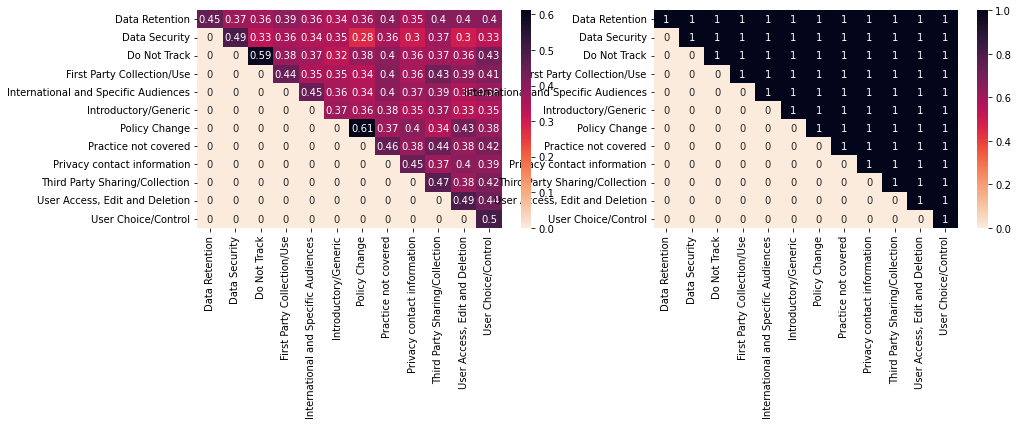

**********************************************************************
paraphrase-MiniLM-L6-v2
before
max: 0.49, min: -0.04, avg: 0.17
41.72
after
max: 0.83, min: -0.11, avg: 0.31
51.10


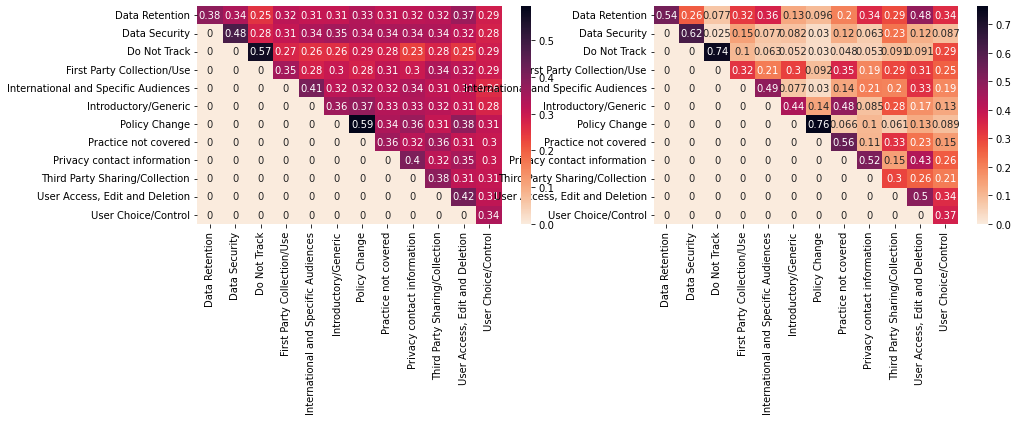

**********************************************************************
all-mpnet-base-v1
before
max: 0.46, min: -0.11, avg: 0.17
42.77
after
max: 0.92, min: 0.10, avg: 0.48
51.00


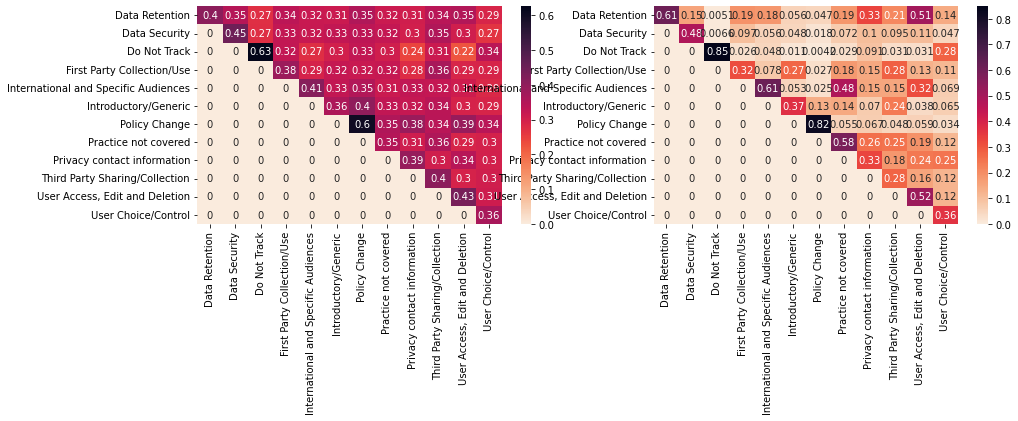

**********************************************************************
all-mpnet-base-v2
before
max: 0.46, min: -0.10, avg: 0.16
45.22
after
max: 0.92, min: -0.17, avg: 0.38
53.58


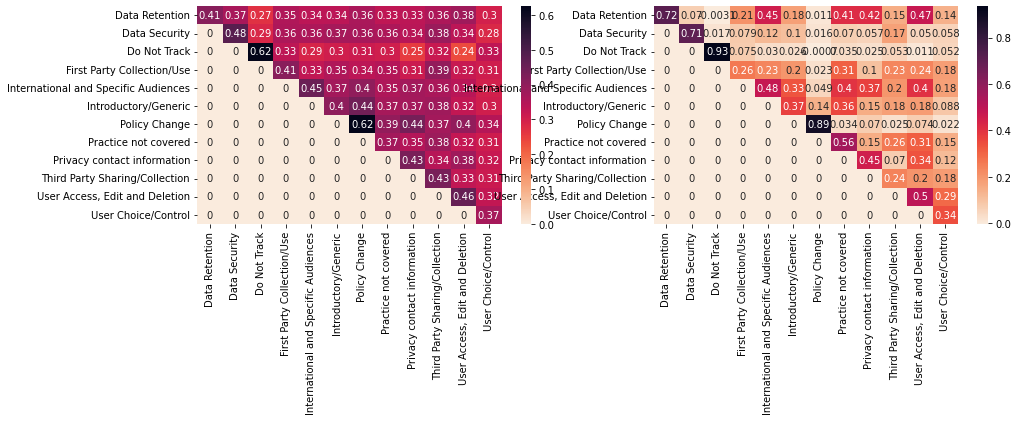

**********************************************************************
distiluse-base-multilingual-cased-v1
before
max: 0.45, min: -0.15, avg: 0.17
37.11
after
max: 0.84, min: -0.28, avg: 0.23
44.03


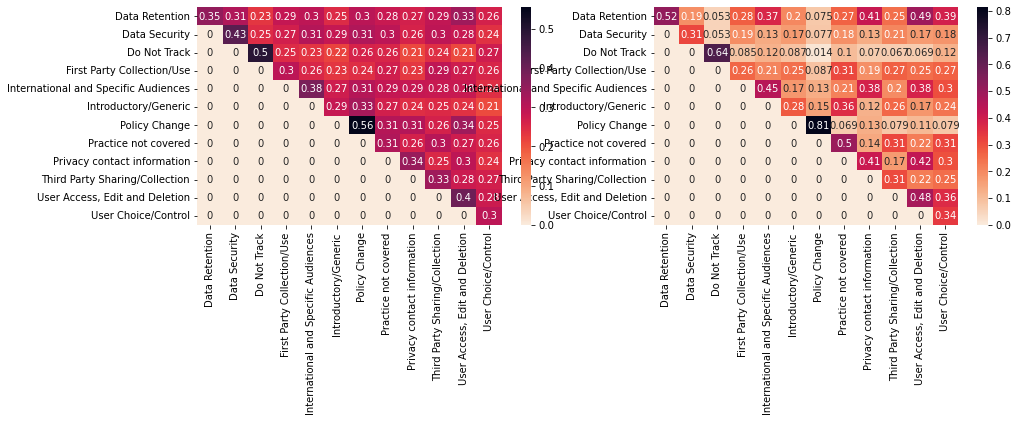

**********************************************************************


In [21]:
for k,v in tuning_results.items():
    print(k)
    print('before')
    scoring(v[0])
    print('after')
    scoring(v[1])
    
    # fig, axes = plt.subplots(1, 2, figsize=(16,5), squeeze=False)
    fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
    ax1, ax2 = axes
    sns.heatmap(v[0].fillna(0), annot=True,
                        xticklabels=v[0].columns,
                        yticklabels=v[0].columns, ax=ax1, cmap="rocket_r")
    sns.heatmap(v[1].fillna(0), annot=True,
                        xticklabels=v[1].columns,
                        yticklabels=v[1].columns, ax=ax2, cmap="rocket_r")

    plt.show()

    print('*'*70)

In [ ]:
embedding_method = 'all-mpnet-base-v1'
X_num = utilities.vectorize_data(X, embedding_method)

In [ ]:
while True:
    
    sim_df_before = calculate_similarity_matrix(X_num, y)
    
    
    train_set = create_train_data(X, y, sample_size=25)
    model = SentenceTransformer(embedding_method, device='cuda') 

    train_dataloader = DataLoader(train_set, shuffle=True, batch_size=6)
    train_loss = losses.CosineSimilarityLoss(model)

    model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=20, warmup_steps=50)

    X_num_tuned = vectorize_data(X, model)
    X_num_tuned = pd.Series([np.squeeze(i) for i in X_num_tuned])
    sim_df_after = calculate_similarity_matrix(X_num_tuned, y)
    
    tuning_results[embedding_method] = (sim_df_before, sim_df_after)
    
    with open(result_file_name, 'wb') as f:
        pickle.dump(tuning_results, f)

In [24]:
df1 = tuning_results['all-mpnet-base-v1'][1]

In [ ]:
col1 - col1 > 0.5
col1 - col2 < 0.2

In [37]:
total_samples = dict(y.sum())
total_samples

{'Data Retention': 78,
 'Data Security': 207,
 'Do Not Track': 31,
 'First Party Collection/Use': 1181,
 'International and Specific Audiences': 296,
 'Introductory/Generic': 378,
 'Policy Change': 116,
 'Practice not covered': 129,
 'Privacy contact information': 202,
 'Third Party Sharing/Collection': 931,
 'User Access, Edit and Deletion': 147,
 'User Choice/Control': 352}

In [45]:
for col in df1.columns:
    samples[col] = 30
for col1, col2 in combinations(df1.columns, 2):
    samples[(col1, col2)] = 30


2.5

0.15247251248089363
0.0050955814467963665
0.19053957596423174
0.18193453857800973
0.05554512012560466
0.046970639143087245
0.18548652876642555
0.3298383327676914
0.21134452986038188
0.5060226128717803
0.1420920917598035
0.006618138719647776
0.09650098311358112
0.05589526666919344
0.048162235459947904
0.01840097261123476
0.07186578027533043
0.09956731076180178
0.09541932318604503
0.10505127997268554
0.046735819213637626
0.025856011530239476
0.04795637765928036
0.011255708576790428
0.004217480236898102
0.02881976814607149
0.09109638467312871
0.030679260624624
0.031186503701652962
0.27924294985929815
0.0777606402676437
0.2748600829044427
0.0266802598949999
0.17714040680976578
0.14802091092089503
0.2840126437485012
0.1279993891711422
0.11401304565897687
0.052805252831453146
0.025152984016638524
0.4815428619459802
0.15216231936904798
0.1501492551862665
0.31780089467889105
0.06856160214076883
0.1331644501080798
0.14335574020209113
0.06967283211287777
0.23660396804985825
0.03814854661256408
0

In [33]:
df1.columns

Index(['Data Retention', 'Data Security', 'Do Not Track',
       'First Party Collection/Use', 'International and Specific Audiences',
       'Introductory/Generic', 'Policy Change', 'Practice not covered',
       'Privacy contact information', 'Third Party Sharing/Collection',
       'User Access, Edit and Deletion', 'User Choice/Control'],
      dtype='object')

<AxesSubplot:>

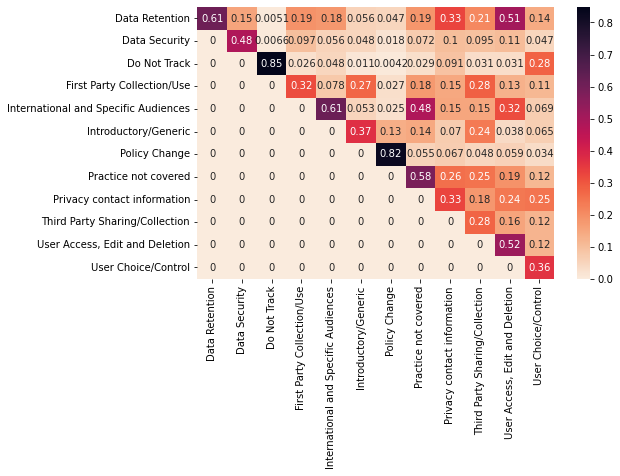

In [31]:
plt.figure(figsize=(8,5))
sns.heatmap(df1.fillna(0), annot=True,
                        xticklabels=df1.columns,
                        yticklabels=df1.columns, cmap="rocket_r")

In [ ]:
for k,v in tuning_results.items():
    print(k)
    print('before')
    scoring(v[0])
    print('after')
    scoring(v[1])

In [ ]:
df1 = tuning_results['stsb-roberta-large'][1]

In [ ]:
samples = {}
for col1, col2 in list(combinations(df1.columns, 2)):
    if df1.loc[col1, col2] > 0.2:
        samples[(col1, col2)] = 100

In [52]:
aa = df1.copy()

In [53]:
for col1, col2 in combinations(aa.columns, 2):
    aa.loc[col2, col1] = aa.loc[col1, col2] 

In [59]:
aa.loc['Data Retention'].drop('Data Retention')

Data Security                           0.152473
Do Not Track                            0.005096
First Party Collection/Use               0.19054
International and Specific Audiences    0.181935
Introductory/Generic                    0.055545
Policy Change                           0.046971
Practice not covered                    0.185487
Privacy contact information             0.329838
Third Party Sharing/Collection          0.211345
User Access, Edit and Deletion          0.506023
User Choice/Control                     0.142092
Name: Data Retention, dtype: object

In [56]:
max(aa.loc['Data Retention'])

0.6127689723762602

In [46]:
np.diag(df1).sum()

6.135939922275348

In [ ]:
def scoring(simdf):    
    scores = calculate_matrix_score(sim_df)[:-1]
    print(f'{embedding} --- max: {max(scores):.2f}, min: {min(scores):.2f}, avg: {sum(scores)/len(scores):.2f}')

    l_sum = 100*np.diag(sim_df).sum()/12 - (sim_df.sum().sum()-np.diag(sim_df).sum())/66
    print(f'{l_sum:.2f}')  

In [ ]:
plt.figure(figsize=(7,5))

sns.heatmap(sim_df.fillna(0), annot=True,
xticklabels=sim_df.columns,
yticklabels=sim_df.columns, cmap="rocket_r")

plt.show()

#### for opp-115
sample_size_by_category = {'Data Retention':40, 'Data Security':20, 'Do Not Track':10,
                            'First Party Collection/Use':80, 'International and Specific Audiences':80,
                            'Introductory/Generic':80, 'Policy Change':10, 'Practice not covered':80,
                            'Privacy contact information':60, 'Third Party Sharing/Collection':60,
                            'User Access, Edit and Deletion':60, 'User Choice/Control':60}

In [ ]:
sum_after = 100*np.diag(sim_df_after).sum()/12 - (sim_df_after.sum().sum()-np.diag(sim_df_after).sum())/66
print(f'{sum_after:.2f}')  

In [ ]:
plt.figure(figsize=(7,5))

sns.heatmap(sim_df_after.fillna(0), annot=True,
xticklabels=sim_df.columns,
yticklabels=sim_df.columns, cmap="rocket_r")

plt.show()

In [ ]:
ss

In [ ]:
y.sum()

plt.figure(figsize=(7,5))

sns.heatmap(sim_df_after.fillna(0), annot=True,
xticklabels=sim_df.columns,
yticklabels=sim_df.columns, cmap="rocket_r")

plt.show()

model = SentenceTransformer(embedding_method, device='cuda') 

train_dataloader = DataLoader(train_set, shuffle=True, batch_size=6)
train_loss = losses.CosineSimilarityLoss(model)


model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=10, warmup_steps=50)

X_num_tuned = vectorize_data(X, model)
X_num_tuned = pd.Series([np.squeeze(i) for i in X_num_tuned])
sim_df_after = calculate_similarity_matrix(X_num_tuned, y)

sum_after = 100*np.diag(sim_df_after).sum()/12 - (sim_df_after.sum().sum()-np.diag(sim_df_after).sum())/66
print(f'{sum_after:.2f}')  

plt.figure(figsize=(7,5))

sns.heatmap(sim_df_after.fillna(0), annot=True,
xticklabels=sim_df.columns,
yticklabels=sim_df.columns, cmap="rocket_r")

plt.show()

In [ ]:
result = {}

for embedding in sentence_embeddings:
    
    model = SentenceTransformer(embedding_method, device='cuda') 

    train_dataloader = DataLoader(train_set, shuffle=True, batch_size=6)
    train_loss = losses.CosineSimilarityLoss(model)

    model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=7, warmup_steps=50)
    X_num_tuned = vectorize_data(X, model)
    X_num_tuned = pd.Series([np.squeeze(i) for i in X_num_tuned])
    sim_df_after = calculate_similarity_matrix(X_num_tuned, y)
    
    result[embedding] = sim_df_after

In [ ]:
for sentence, sim_df_after in result.items():
    sum_after = 100*np.diag(sim_df_after).sum()/12 - (sim_df_after.sum().sum()-np.diag(sim_df_after).sum())/66
    print('-'*30)
    print(sentence)
    
    print(f'{sum_after:.2f}')  
    
    plt.figure(figsize=(8,6))

    sns.heatmap(sim_df_after.fillna(0), annot=True,
    xticklabels=sim_df.columns,
    yticklabels=sim_df.columns, cmap="rocket_r")

    plt.show()

In [ ]:
import pickle
filehandler = open(b"emb_tuning_reuters.p","wb")
pickle.dump(result,filehandler)

In [ ]:
model = SentenceTransformer('bert-base-nli-mean-tokens', device='cuda') 

train_dataloader = DataLoader(train_set, shuffle=True, batch_size=6)
train_loss = losses.CosineSimilarityLoss(model)


model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=10, warmup_steps=50)

In [ ]:
X_num_tuned = vectorize_data(X, model)
X_num_tuned = pd.Series([np.squeeze(i) for i in X_num_tuned])
sim_df_after = calculate_similarity_matrix(X_num_tuned, y)

sum_after = 100*np.diag(sim_df_after).sum()/12 - (sim_df_after.sum().sum()-np.diag(sim_df_after).sum())/66
print(f'{sum_after:.2f}')  

In [ ]:
plt.figure(figsize=(7,5))

sns.heatmap(sim_df_after.fillna(0), annot=True,
xticklabels=sim_df.columns,
yticklabels=sim_df.columns, cmap="rocket_r")

plt.show()